This notebook enables to evaluate ResNet-50 model.

In [1]:
import csv

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tqdm import tqdm

from utils.eval.eval_utils import compute_ROC
from utils.training.data_loading import get_load_spectro_for_class
from utils.training.keras_models import resnet

2024-01-03 15:26:39.093928: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-03 15:26:39.288401: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-03 15:26:39.288435: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-03 15:26:39.289210: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-03 15:26:39.366992: I tensorflow/core/platform/cpu_feature_g

## Parameters

In [19]:
ROOT_DIR = "/path/to/the/dataset"  # path where we expect to find directories named "postives", "negatives" and a csv file
OUTPUT_DIR = "ResNet-50/dataset"  # directory where to output files, in the data folder
BATCH_SIZE = 64
epoch = 31  # epoch checkpoint that we want to load
CHECKPOINT = f"../../../../data/model_saves/ResNet-50/all/cp-{epoch:04d}.ckpt"

ALLOWED_ERROR_S = 10  # tolerance when evaluating and time distance allowed between two peaks in the probabilities distribution

load = get_load_spectro_for_class(224, 3)

## Load model

In [20]:
m = resnet()
m.load_weights(CHECKPOINT)
m.compile(
            optimizer=tf.keras.optimizers.legacy.Adam(),
            loss=tf.losses.binary_crossentropy,
            metrics=['Accuracy','AUC'])

## Load data

In [21]:
with open(ROOT_DIR + "/dataset.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",")
    lines = list(csv_reader)
print(len(lines), "files found")
lines = [l[0] for l in lines]
dataset = tf.data.Dataset.from_tensor_slices(lines)
dataset = dataset.map(load).batch(batch_size=BATCH_SIZE)

31104 files found


## Model execution

In [22]:
detected = []
ground_truth = []

for images, y in tqdm(dataset, total=1+int(len(lines)/BATCH_SIZE)):
    predicted = m.predict(images, verbose=False)
    detected.extend(predicted[:,0])
    ground_truth.extend(y)
    
detected = np.array(detected)
ground_truth = np.array(ground_truth)    

 78%|███████▊  | 379/487 [02:36<00:44,  2.44it/s]

100%|█████████▉| 486/487 [03:21<00:00,  2.41it/s]


## ROC curve computing

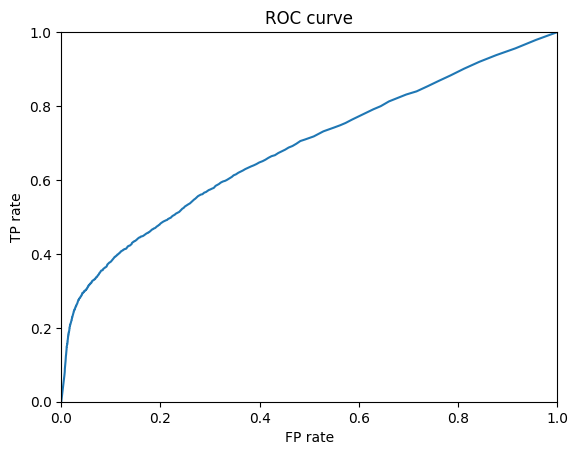

In [23]:
TPr, FPr = compute_ROC(detected[ground_truth==1], np.count_nonzero(ground_truth==1), detected[ground_truth==0], np.count_nonzero(ground_truth==0), thresh_delta=0.001)
plt.plot(FPr, TPr)
np.save(f"../../../../data/npy/{OUTPUT_DIR}/FPr.npy", FPr)
np.save(f"../../../../data/npy/{OUTPUT_DIR}/TPr.npy", TPr)
plt.xlim(0,1)
plt.ylim(0,1)
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.title("ROC curve")
plt.savefig(f"../../../../data/figures/{OUTPUT_DIR}/ROC.png")